Data: Journey to Springfield Dataset (dlschool. (2018). Journey to Springfield. Kaggle. https://kaggle.com/competitions/journey-to-springfield)

In [ ]:
import torch
import numpy as np

import PIL # cv2 is better

In [ ]:
import pickle

from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path

from torchvision import transforms, datasets, models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler


from matplotlib import colors, pyplot as plt
%matplotlib inline

In [ ]:
# fix random seed
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

### Data paths loading

In [ ]:
!unzip -q /content/drive/MyDrive/Deep_learning/Terra_Quantum/DL_seminars/seminar_4/simpsons4.zip -d dataset

In [ ]:
# dataset modes
DATA_MODES = ['train', 'val', 'test']
# all images will be scaled to the size of 224x224 px
RESCALE_SIZE = 224
# device setting
DEVICE = torch.device("cuda")

In [ ]:
TRAIN_DIR = Path('/content/dataset/train/simpsons_dataset')
TEST_DIR = Path('/content/dataset/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
train_files[:5]

[PosixPath('/content/dataset/train/simpsons_dataset/chief_wiggum/pic_0127.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/bart_simpson/pic_1270.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/krusty_the_clown/pic_0579.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/sideshow_bob/pic_0863.jpg'),
 PosixPath('/content/dataset/train/simpsons_dataset/ned_flanders/pic_0699.jpg')]

### Dataset module

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Dataset with pictures, which loads them from folders,
    scales and turns into torch tensors
    """
    def __init__(self, files, mode):
        super().__init__()
        # download list
        self.files = sorted(files)
        # dataset mode
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)


        self.transform =  transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # converts images into PyTorch tensors and normalize

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')

        if self.mode == 'test':
            x = self.transform(x)
            return x

        elif self.mode == 'train':
            # in case mode == 'train' the transformation and augmentations will
            # take place directly in the fit_epoch() function for each batch
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        elif self.mode == 'val':
            x = self.transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title, fontsize = 10)
    plt_ax.grid(False)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

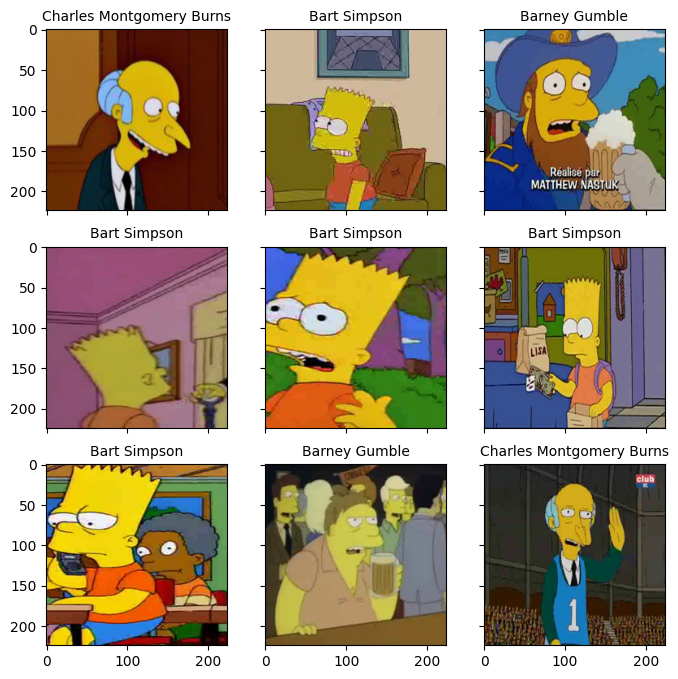

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Imbalanced data adressing

In [ ]:
train_labels = [path.parent.name for path in train_files]

In [ ]:
from collections import Counter
c = Counter(train_labels).most_common()[::-1]
c

[('lionel_hutz', 2),
 ('troy_mcclure', 6),
 ('disco_stu', 6),
 ('miss_hoover', 13),
 ('gil', 20),
 ('fat_tony', 20),
 ('otto_mann', 24),
 ('sideshow_mel', 30),
 ('agnes_skinner', 32),
 ('rainier_wolfcastle', 34),
 ('cletus_spuckler', 35),
 ('snake_jailbird', 41),
 ('professor_john_frink', 49),
 ('martin_prince', 53),
 ('patty_bouvier', 54),
 ('ralph_wiggum', 67),
 ('carl_carlson', 74),
 ('selma_bouvier', 77),
 ('barney_gumble', 80),
 ('groundskeeper_willie', 91),
 ('maggie_simpson', 96),
 ('waylon_smithers', 136),
 ('mayor_quimby', 185),
 ('lenny_leonard', 233),
 ('nelson_muntz', 269),
 ('edna_krabappel', 343),
 ('comic_book_guy', 352),
 ('kent_brockman', 373),
 ('apu_nahasapeemapetilon', 467),
 ('sideshow_bob', 658),
 ('abraham_grampa_simpson', 685),
 ('chief_wiggum', 739),
 ('milhouse_van_houten', 809),
 ('principal_skinner', 895),
 ('charles_montgomery_burns', 895),
 ('krusty_the_clown', 904),
 ('marge_simpson', 968),
 ('bart_simpson', 1006),
 ('lisa_simpson', 1015),
 ('moe_szyslak'

Trainig set is highly imbalanced, we need to perform data balancing by means of augmentation

In [ ]:
transform = transforms.Compose([
            transforms.ColorJitter(0.6, 0.6, 0.6, 0),
            transforms.RandomHorizontalFlip(),
        ])

In [ ]:
char_lib = dict(c)
REQUIRED_SIZE = 400


for charecter_name in tqdm(np.array(c)[:,0]):
    paths = np.where(np.array(train_labels) == charecter_name)[0]

    num_added_imgs = 0
    num_augs_per_img = REQUIRED_SIZE // char_lib[charecter_name]

    for img_path in tqdm(paths):
        for i in range(num_augs_per_img):
            num_added_imgs += 1
            image = Image.open(train_files[img_path])
            image.load()

            new_image = transform(image)
            image_name = str(train_files[img_path])
            new_image_name = image_name[:-8] + str(i) + image_name[-7:]
            new_image.save(new_image_name)

            train_files.append(Path(new_image_name))
        if num_added_imgs >= REQUIRED_SIZE:
            break

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/343 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

  0%|          | 0/658 [00:00<?, ?it/s]

  0%|          | 0/685 [00:00<?, ?it/s]

  0%|          | 0/739 [00:00<?, ?it/s]

  0%|          | 0/809 [00:00<?, ?it/s]

  0%|          | 0/895 [00:00<?, ?it/s]

  0%|          | 0/895 [00:00<?, ?it/s]

  0%|          | 0/904 [00:00<?, ?it/s]

  0%|          | 0/968 [00:00<?, ?it/s]

  0%|          | 0/1006 [00:00<?, ?it/s]

  0%|          | 0/1015 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1090 [00:00<?, ?it/s]

  0%|          | 0/1684 [00:00<?, ?it/s]

### The result of data balancing:

In [ ]:
train_labels = [path.parent.name for path in train_files]

from collections import Counter
c = Counter(train_labels).most_common()[::-1]
c

[('lionel_hutz', 402),
 ('troy_mcclure', 402),
 ('disco_stu', 402),
 ('ralph_wiggum', 402),
 ('miss_hoover', 403),
 ('otto_mann', 408),
 ('rainier_wolfcastle', 408),
 ('waylon_smithers', 408),
 ('snake_jailbird', 410),
 ('agnes_skinner', 416),
 ('cletus_spuckler', 420),
 ('sideshow_mel', 420),
 ('gil', 420),
 ('fat_tony', 420),
 ('martin_prince', 424),
 ('patty_bouvier', 432),
 ('professor_john_frink', 441),
 ('carl_carlson', 444),
 ('groundskeeper_willie', 455),
 ('selma_bouvier', 462),
 ('lenny_leonard', 466),
 ('apu_nahasapeemapetilon', 467),
 ('maggie_simpson', 480),
 ('barney_gumble', 480),
 ('nelson_muntz', 538),
 ('mayor_quimby', 555),
 ('sideshow_bob', 658),
 ('abraham_grampa_simpson', 685),
 ('edna_krabappel', 686),
 ('comic_book_guy', 704),
 ('chief_wiggum', 739),
 ('kent_brockman', 746),
 ('milhouse_van_houten', 809),
 ('principal_skinner', 895),
 ('charles_montgomery_burns', 895),
 ('krusty_the_clown', 904),
 ('marge_simpson', 968),
 ('bart_simpson', 1006),
 ('lisa_simpson'

### Model

Hierarchy of features

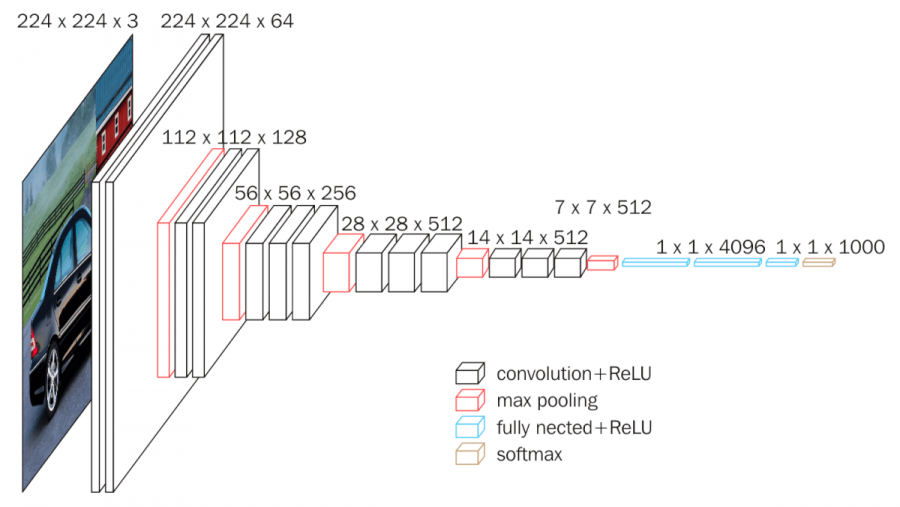

ResNet Architecture

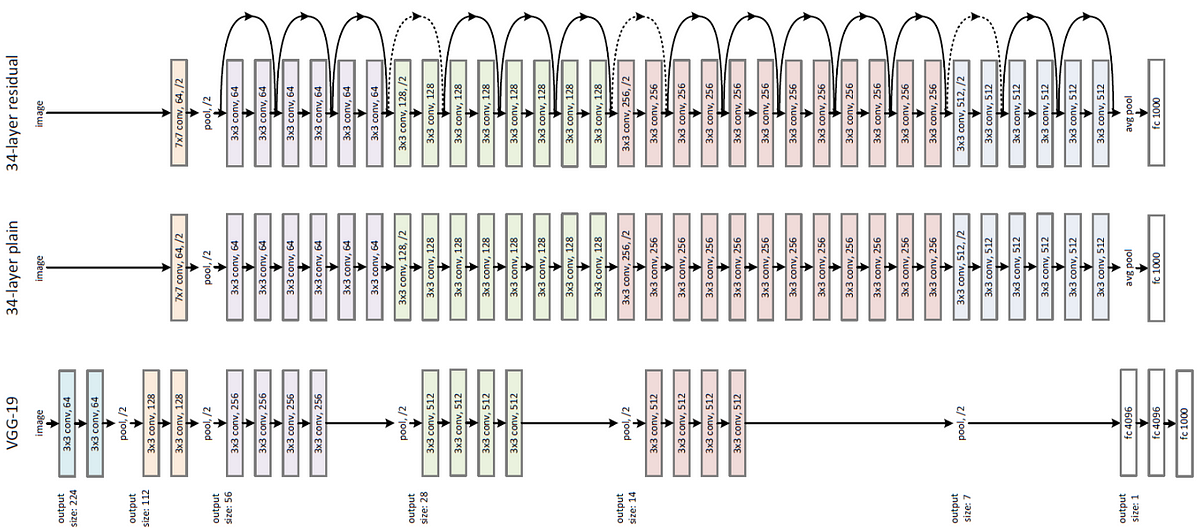

In [ ]:
model = models.resnet152(weights='IMAGENET1K_V2')

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 80.7MB/s]


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Freeze first N blocs of the model and replace the Head

In [ ]:
model_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

Number of trainable parameters: 60192808


In [ ]:
# freezing first N blocks of parameters
N = 7

for (i, child) in enumerate(model.children()):
    # only for first N blocks
    if i < N:
        for param in child.parameters():
            param.requires_grad = False

In [ ]:
model_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

Number of trainable parameters: 17013736


In [ ]:
# num_features -- the size of features vector that comes to the input of fc-layer
num_features = 2048
# replace the Fully-Connected layer with our linear classifier
model.fc = nn.Linear(num_features, 42)

model = model.cuda()



#### Train loop

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):

    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    train_transform = transforms.Compose([
            transforms.ColorJitter(0.6, 0.6, 0.6, 0),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    for inputs, labels in tqdm(train_loader):
        # transformations with augmentations:
        inputs = inputs.float().permute(0,3,1,2).to(DEVICE)
        labels = labels.to(DEVICE)
        inputs = train_transform(inputs)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.float().to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size,
          save_dir = './experiments/version_0/', prev_best_val_loss=None):

    if prev_best_val_loss is None:
        best_val_loss = torch.inf
    else:
        best_val_loss = prev_best_val_loss

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        optimizer = torch.optim.AdamW(model.parameters(), lr= 0.0001)
        criterion = nn.CrossEntropyLoss()
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.03)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_loss < best_val_loss:
                best_val_loss = val_loss

                torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': val_loss,
                            }, save_dir + 'best_checkpoint.pth') # change directory to one on google drive!!!

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            # scheduler.step()

    # save last state for trainig resuming
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                }, save_dir + 'last_checkpoint.pth')

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=6, batch_size=75, save_dir='./')

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

loss 1.2644805656155478

Epoch 001 train_loss: 1.2645     val_loss 0.3038 train_acc 0.7052 val_acc 0.9205


  0%|          | 0/347 [00:00<?, ?it/s]

loss 0.21021096101057257

Epoch 002 train_loss: 0.2102     val_loss 0.2428 train_acc 0.9411 val_acc 0.9389


  0%|          | 0/347 [00:00<?, ?it/s]

loss 0.09600462614848819

Epoch 003 train_loss: 0.0960     val_loss 0.2098 train_acc 0.9735 val_acc 0.9494


  0%|          | 0/347 [00:00<?, ?it/s]

loss 0.06980826466213781

Epoch 004 train_loss: 0.0698     val_loss 0.2139 train_acc 0.9815 val_acc 0.9511


  0%|          | 0/347 [00:00<?, ?it/s]

loss 0.05226354817280981

Epoch 005 train_loss: 0.0523     val_loss 0.2178 train_acc 0.9845 val_acc 0.9513


  0%|          | 0/347 [00:00<?, ?it/s]

loss 0.04119995184453157

Epoch 006 train_loss: 0.0412     val_loss 0.2006 train_acc 0.9886 val_acc 0.9578


In [ ]:
train_loss, train_acc, val_loss, val_acc = zip(*history)

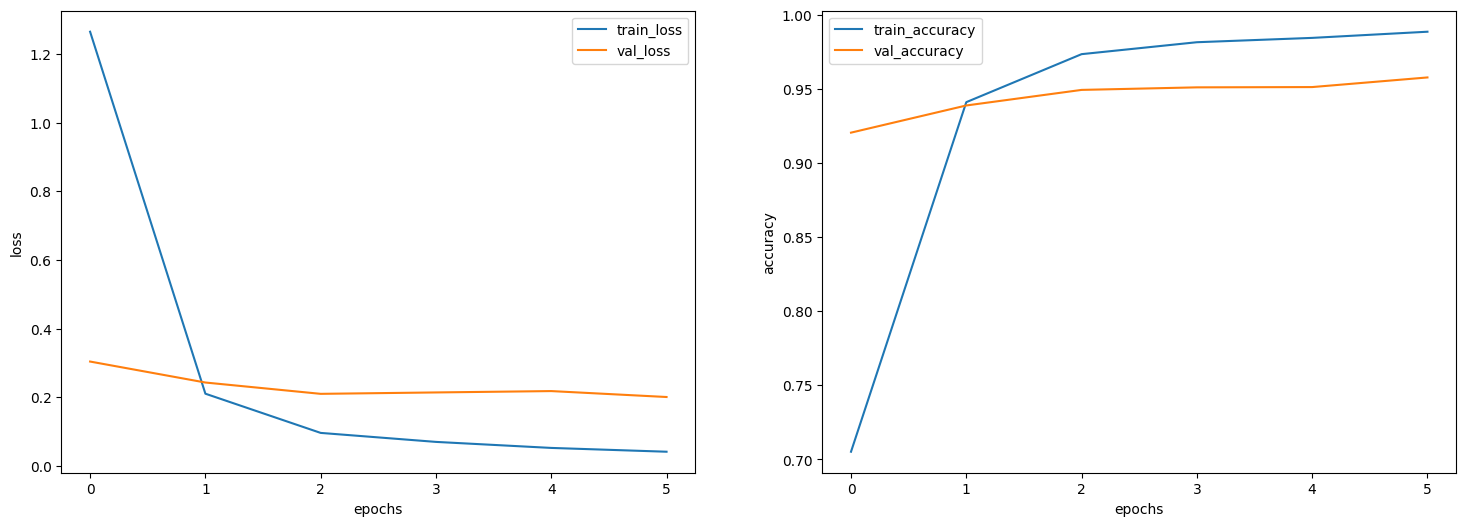

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(train_loss, label="train_loss")
ax[0].plot(val_loss, label="val_loss")
ax[0].legend()
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")

ax[1].plot(train_acc, label="train_accuracy")
ax[1].plot(val_acc, label="val_accuracy")
ax[1].legend()
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
plt.show()

### Results

In [ ]:
save_dir = 'best_checkpoint.pth'
checkpoint = torch.load(save_dir)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """prediction for one picture"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

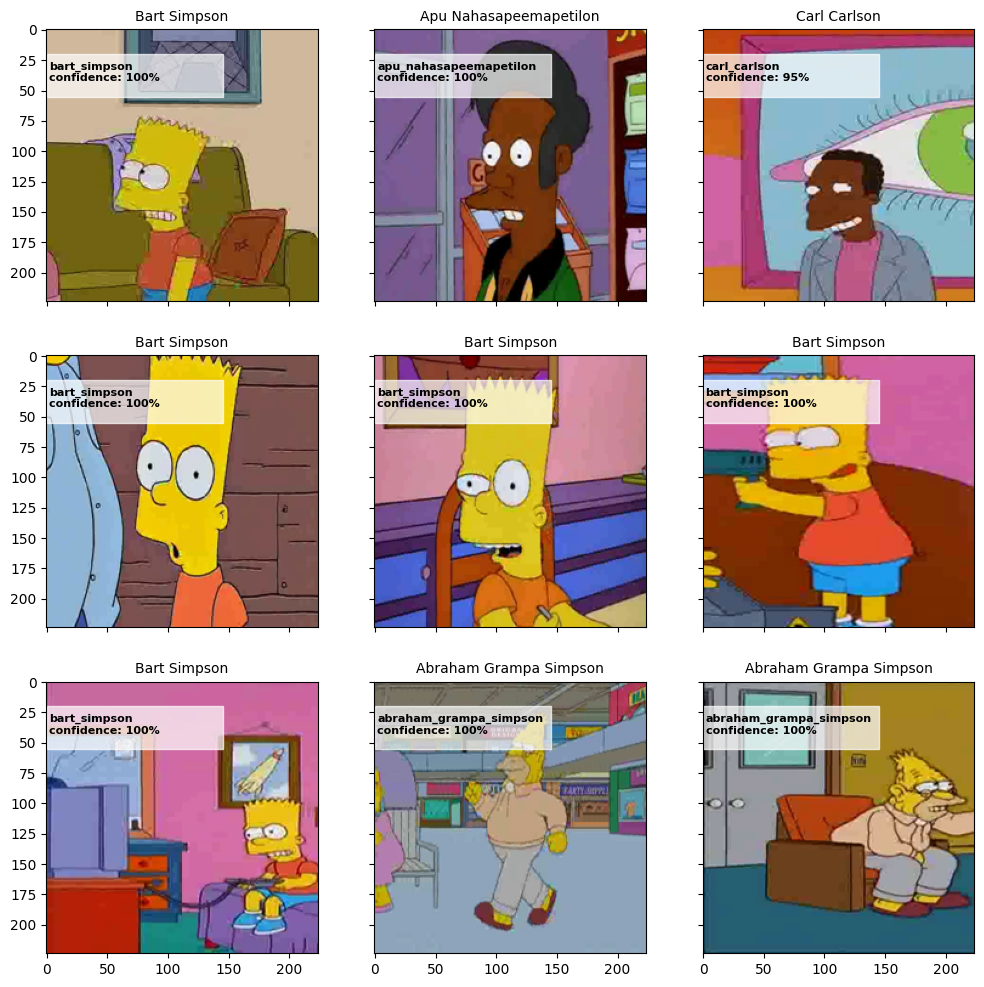

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 20), 145, 35, color='white', alpha=0.7))
    font0 = FontProperties()
    font = font0.copy()
    # font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_text = "{}\nconfidence: {:.0f}%".format(predicted_label, predicted_proba)

    fig_x.text(2, 26, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')